## Eawag Readers Workspace

In [1]:
# imports
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyrsktools as rsk
import matplotlib.pyplot as plt
import seaborn as sns

from mooring_reader import MooringReader

### CTD Transect Data

#### Separate profiles from RBR CTD

In [2]:
os.listdir('Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/VerticalProfiles/to_be_processed/20251030/')

['066131_20251030_1318.rsk',
 '066131_20251030_1318.zip',
 '066131_20251030_1318_1.meta',
 '066131_20251030_1318_1.nc',
 '066131_20251030_1318_10.nc',
 '066131_20251030_1318_11.nc',
 '066131_20251030_1318_12.nc',
 '066131_20251030_1318_2.nc',
 '066131_20251030_1318_3.nc',
 '066131_20251030_1318_4.nc',
 '066131_20251030_1318_5.nc',
 '066131_20251030_1318_6.nc',
 '066131_20251030_1318_7.nc',
 '066131_20251030_1318_8.nc',
 '066131_20251030_1318_9.nc',
 'md.json']

In [108]:
fpath = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/VerticalProfiles/to_be_processed/20251030/066131_20251030_1318.rsk'
serial_id = '66131'

In [115]:
def separate_profiles_RBR_L0(fpath, serial_id):
    SID_BRAND_MAP = {'1807': 'Sea&Sun', '2023': 'Sea&Sun', '66131': 'RBR'}

    brand = SID_BRAND_MAP[serial_id]
    if brand != 'RBR':
        raise ValueError("Only RBR CTD L0 data requires profile separation.")

    froot, ext = os.path.splitext(fpath)
    if ext != '.rsk':
        raise ValueError("Only RBR CTD L0 .rsk files require profile separation.")

    with rsk.RSK(fpath) as f:
        f.readdata()
        data = f.data

        # find indices of each profile
        f.computeprofiles()
        profiles_idx = f.getprofilesindices(direction='both')

    # separate profiles and write out
    profiles = []
    for i, p_idx in enumerate(profiles_idx):
        p_data = pd.DataFrame(data[p_idx])
        p_data = p_data.set_index('timestamp')
        ds = xr.Dataset.from_dataframe(p_data)
        out_path = froot + f'_{i+1}.nc'
        profiles.append((out_path, ds))

        ds.to_netcdf(out_path, mode='w', format='NETCDF4')

    return profiles

In [116]:
profiles = separate_profiles_RBR_L0(fpath, serial_id)
profiles

Ruskin profile and cast annotations will be deleted as they might conflict with the new profiles detected


[('Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/VerticalProfiles/to_be_processed/20251030/066131_20251030_1318_1.nc',
  <xarray.Dataset> Size: 63kB
  Dimensions:                     (timestamp: 608)
  Coordinates:
    * timestamp                   (timestamp) datetime64[ms] 5kB 2025-10-30T09:...
  Data variables:
      conductivity                (timestamp) float64 5kB 0.201 ... 0.007146
      temperature                 (timestamp) float64 5kB 11.93 12.67 ... 13.11
      pressure                    (timestamp) float64 5kB 9.684 9.78 ... 9.58
      temperature1                (timestamp) float64 5kB 12.78 12.82 ... 13.09
      dissolved_o2_concentration  (timestamp) float64 5kB 296.9 297.8 ... 265.6
      turbidity                   (timestamp) float64 5kB 2.224 1.144 ... 110.1
      sea_pressure                (timestamp) float64 5kB -0.4485 ... -0.5529
      depth                       (timestamp) float64 5kB -0.4574 ... -0.5638
      salinity                    (timestamp) floa

In [ ]:
# convert from UTC to Swiss time
data['timestamp'] = data['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')

# filter out data from day before (test)
data = data[data['timestamp'] >= pd.Timestamp('2025-10-30', tz='Europe/Zurich')]

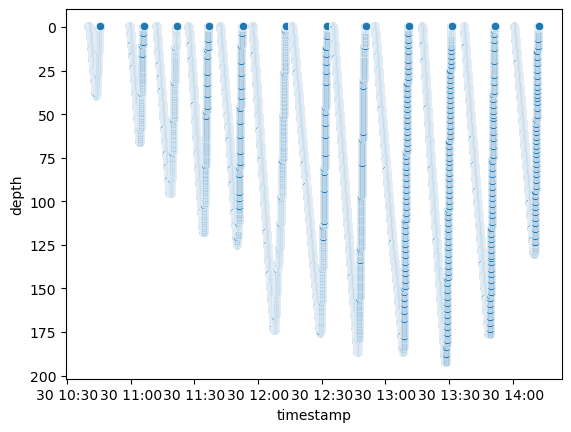

In [37]:
fig, ax = plt.subplots()

sns.scatterplot(data, x='timestamp', y='depth')

ax.invert_yaxis()
plt.show()

### Mooring Data

In [2]:
lake = 'Zugersee'
location = 'LZ1'
year = '2025'
date = '20250424'
bathy_file = '../../../data/lake_zug/bathymetry/zugersee_bathy.nc'

reader = MooringReader(lake, location, year, date, bathy_file)

In [3]:
reader.__dict__

{'lake': 'Zugersee',
 'location': 'LZ1',
 'year': '2025',
 'date': '20250424',
 'bathy_file': '../../../data/lake_zug/bathymetry/zugersee_bathy.nc',
 'datalakes': False,
 'md_file': 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1_md.json'}

#### Load oxygen logger data into xarray Dataset

In [30]:
import dolfyn as dlfn

In [31]:
ds = dlfn.read(f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/6D728000.000')


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/6D728000.000 ...


In [32]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:              (time: 14243, dir: 4, range: 45, beam: 4, x: 4, x*: 4,
                          earth: 3, inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 114kB 2025-01-15T12:12:27.0224...
  * dir                  (dir) <U3 48B 'E' 'N' 'U' 'err'
  * range                (range) float64 360B 2.08 3.08 4.08 ... 45.08 46.08
  * beam                 (beam) int64 32B 1 2 3 4
  * x                    (x) int64 32B 1 2 3 4
  * x*                   (x*) int64 32B 1 2 3 4
  * earth                (earth) <U1 12B 'E' 'N' 'U'
  * inst                 (inst) <U1 12B 'X' 'Y' 'Z'
Data variables: (12/21)
    number               (time) uint32 57kB 1 2 3 4 ... 14240 14241 14242 14243
    builtin_test_fail    (time) bool 14kB False False False ... False False
    c_sound              (time) float32 57kB 1.476e+03 1.474e+03 ... 1.449e+03
    depth                (time) float32 57kB 150.0 150.0 150.0 ... 150.0 150.0
    pitch                (time) float32 57kB 24.88 24.73 24.73 ... 1.92 3.69
    roll                 (time) float32 57kB 14.58 7.73 7.55 ... -25.94 -25.95
    ...                   ...
    vel                  (dir, range, time) float32 10MB nan nan nan ... nan nan
    amp                  (beam, range, time) uint8 3MB 41 41 41 41 ... 42 42 42
    corr                 (beam, range, time) uint8 3MB 17 16 13 13 ... 75 11 0 0
    prcnt_gd             (beam, range, time) uint8 3MB 0 0 0 0 0 ... 25 0 0 0 0
    beam2inst_orientmat  (x, x*) float64 128B 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float64 1MB 0.9562 ... -0.8977
Attributes: (12/39)
    inst_make:                TRDI
    inst_type:                ADCP
    rotate_vars:              ['vel']
    has_imu:                  0
    prog_ver:                 51.42
    inst_model:               Workhorse
    ...                       ...
    transmit_lag_m:           0.23
    bandwidth:                0
    power_level:              255
    serialnum:                1728
    fs:                       0.007142857142857143
    vel_gps_corrected:        0

In [48]:
serial_id = '893460'
depth = 100
sensor = 'minidot'
fpath = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/7450-{serial_id}/Cat.txt'
fpath

'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/7450-893460/Cat.txt'

In [49]:
def load_from_L0(fpath, sensor, depth, serial_id):
    cols_drop = ['Unix Timestamp', 'Coordinated Universal Time', 'Battery', 'Q']

    cols_map = {
        'UTC_Date_&_Time': 'time',
        'Temperature': 'temp',
        'Dissolved Oxygen': 'd_oxygen',
        'Dissolved Oxygen Saturation': 'd_oxygen_sat'
    }
    
    if sensor == 'minidot':
        with open(fpath, 'r') as f:
            lines = [x[:-1] for x in f if len(x.split(',')) > 1]

        # extract column names and units
        cols = [x.lstrip(' ') for x in lines[0].split(',')]

        data = []
        for line in lines[2:]:
            data.append([x.lstrip(' ') for x in line.split(',')])
        data = pd.DataFrame(data, columns=cols)

        data = data.drop(cols_drop, axis=1)
        data = data.rename(columns=cols_map)
        data['time'] = pd.to_datetime(data['time'])
        data['temp'] = data['temp'].astype(float)
        data['d_oxygen'] = data['d_oxygen'].astype(float)
        data['d_oxygen_sat'] = data['d_oxygen_sat'].astype(float)
        data = data.set_index('time')

        ds = xr.Dataset.from_dataframe(data)
        ds = ds.assign_coords(depth=depth, serial_id=serial_id)

    return ds

In [50]:
ds = load_from_L0(fpath, sensor, 100, serial_id)
ds

<xarray.Dataset> Size: 5MB
Dimensions:       (time: 151233)
Coordinates:
  * time          (time) datetime64[ns] 1MB 2025-01-09T14:59:00 ... 2025-04-2...
    depth         int64 8B 100
    serial_id     <U6 24B '893460'
Data variables:
    temp          (time) float64 1MB 18.09 18.18 18.18 18.2 ... 21.62 21.62 21.6
    d_oxygen      (time) float64 1MB 8.668 8.636 8.647 ... 8.294 8.281 8.277
    d_oxygen_sat  (time) float64 1MB 96.46 96.27 96.4 ... 99.04 98.89 98.81

In [52]:
serial_id = '899457'
depth = 200
sensor = 'minidot'
fpath = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/7450-{serial_id}/Cat.txt'
fpath

'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/7450-899457/Cat.txt'

In [53]:
ds2 = load_from_L0(fpath, sensor, 200, serial_id)
ds2

<xarray.Dataset> Size: 5MB
Dimensions:       (time: 151227)
Coordinates:
  * time          (time) datetime64[ns] 1MB 2025-01-09T14:49:00 ... 2025-04-2...
    depth         int64 8B 200
    serial_id     <U6 24B '899457'
Data variables:
    temp          (time) float64 1MB 18.59 18.77 18.82 ... 21.98 22.02 22.0
    d_oxygen      (time) float64 1MB 8.501 8.461 8.455 ... 8.153 8.144 8.147
    d_oxygen_sat  (time) float64 1MB 95.57 95.47 95.5 95.6 ... 98.03 98.02 98.01

In [46]:
# rbr_do
serial_id = '201101'
sensor = 'rbr_do'
depth = 300
fpath = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/AUTO_{serial_id}_{date}_1403.rsk'
fpath

'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/AUTO_201101_20250424_1403.rsk'

In [42]:
with rsk.RSK(fpath) as f:
    f.readdata()
    sid = str(f.instrument.serialID)
    data = pd.DataFrame(f.data)

In [45]:
cols_map = {'timestamp': 'time', 'dissolved_o2_saturation': 'd_oxygen_sat'}
data = data.rename(columns=cols_map)
data = data.set_index('time')
data

,d_oxygen_sat
time,
2025-01-15 06:00:00,97.722251
2025-01-15 06:00:10,97.722251
2025-01-15 06:00:20,97.725323
2025-01-15 06:00:30,97.723508
2025-01-15 06:00:40,97.725812
...,...
2025-04-24 14:02:40,102.152837
2025-04-24 14:02:50,102.219246
2025-04-24 14:03:00,102.325388


In [47]:
ds3 = xr.Dataset.from_dataframe(data)
ds3 = ds3.assign_coords(depth=depth, serial_id=serial_id)
ds3

<xarray.Dataset> Size: 14MB
Dimensions:       (time: 858261)
Coordinates:
  * time          (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-2...
    depth         int64 8B 300
    serial_id     <U6 24B '201101'
Data variables:
    d_oxygen_sat  (time) float64 7MB 97.72 97.72 97.73 ... 102.3 102.4 102.7

In [54]:
ds_aligned = xr.align(*[ds, ds2, ds3], join='inner')
ds_combined = xr.concat(ds_aligned, dim='depth')
ds_combined

C:\Users\herremha\AppData\Local\Temp\ipykernel_23180\595018877.py:2: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds_combined = xr.concat(ds_aligned, dim='depth')


<xarray.Dataset> Size: 11MB
Dimensions:       (depth: 3, time: 143044)
Coordinates:
  * time          (time) datetime64[ns] 1MB 2025-01-15T06:00:00 ... 2025-04-2...
  * depth         (depth) int64 24B 100 200 300
    serial_id     (depth) <U6 72B '893460' '899457' '201101'
Data variables:
    temp          (depth, time) float64 3MB 18.09 18.09 18.09 ... nan nan nan
    d_oxygen      (depth, time) float64 3MB 9.198 9.19 9.204 ... nan nan nan
    d_oxygen_sat  (depth, time) float64 3MB 102.3 102.3 102.4 ... 102.3 102.3

#### Load thermistor data into xarray Dataset

In [10]:
# rbr temp
depth = 100
serial_id = '200569'
sensor = 'rbr_temp'
fpath = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/AUTO_{serial_id}_{date}_1356.rsk'
fpath

'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/AUTO_200569_20250424_1356.rsk'

In [5]:
with rsk.RSK(fpath) as f:
    f.readdata()
    serial_id = str(f.instrument.serialID)
    data = pd.DataFrame(f.data)

In [6]:
cols_map = {
    'timestamp': 'time',
    'temperature': 'temp'
}

data = data.rename(columns=cols_map)
data = data.set_index('time')
data

,temp
time,
2025-01-15 06:00:00,16.661611
2025-01-15 06:00:10,16.657880
2025-01-15 06:00:20,16.657910
2025-01-15 06:00:30,16.657086
2025-01-15 06:00:40,16.643454
...,...
2025-04-24 13:55:40,21.118636
2025-04-24 13:55:50,21.115041
2025-04-24 13:56:00,21.073992


In [9]:
ds = xr.Dataset.from_dataframe(data)
ds = ds.assign_coords(depth=depth, serial_id=serial_id)
ds

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 858219)
Coordinates:
  * time       (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-24T1...
    depth      int64 8B 100
    serial_id  <U6 24B '200569'
Data variables:
    temp       (time) float64 7MB 16.66 16.66 16.66 16.66 ... 21.07 21.11 21.27

In [22]:
# rbr duet
depth = 200
serial_id = '081465'
sensor = 'rbr_duet'
fpath = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/AUTO_{serial_id}_{date}_1405.rsk'
fpath

'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250424/LZ1/AUTO_081465_20250424_1405.rsk'

In [23]:
with rsk.RSK(fpath) as f:
    f.readdata()
    #serial_id = str(f.instrument.serialID)
    data = pd.DataFrame(f.data)

In [31]:
cols_map = {
    'timestamp': 'time',
    'temperature': 'temp'
}

data = data.rename(columns=cols_map)
data = data.set_index('time')
data

,temp,pressure
time,,
2025-01-15 06:00:00,18.839134,9.738332
2025-01-15 06:00:10,18.849149,9.738949
2025-01-15 06:00:20,18.860063,9.740281
2025-01-15 06:00:30,18.852684,9.739329
2025-01-15 06:00:40,18.871820,9.740376
...,...,...
2025-04-24 14:04:50,21.243538,9.614637
2025-04-24 14:05:00,21.199077,9.615869
2025-04-24 14:05:10,21.163768,9.613490


In [32]:
ds2 = xr.Dataset.from_dataframe(data)
ds2 = ds2.assign_coords(depth=depth, serial_id=serial_id)
ds2

<xarray.Dataset> Size: 21MB
Dimensions:    (time: 858274)
Coordinates:
  * time       (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-24T1...
    depth      int64 8B 200
    serial_id  <U6 24B '081465'
Data variables:
    temp       (time) float64 7MB 18.84 18.85 18.86 18.85 ... 21.16 21.21 21.41
    pressure   (time) float64 7MB 9.738 9.739 9.74 9.739 ... 9.613 9.612 9.61

In [33]:
ds

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 858219)
Coordinates:
  * time       (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-24T1...
    depth      int64 8B 100
    serial_id  <U6 24B '200569'
Data variables:
    temp       (time) float64 7MB 16.66 16.66 16.66 16.66 ... 21.07 21.11 21.27

In [34]:
ds_aligned

(<xarray.Dataset> Size: 14MB
 Dimensions:    (time: 858219)
 Coordinates:
   * time       (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-24T1...
     depth      int64 8B 100
     serial_id  <U6 24B '200569'
 Data variables:
     temp       (time) float64 7MB 16.66 16.66 16.66 16.66 ... 21.07 21.11 21.27,
 <xarray.Dataset> Size: 27MB
 Dimensions:      (index: 858274)
 Coordinates:
   * index        (index) int64 7MB 0 1 2 3 4 ... 858270 858271 858272 858273
     depth        int64 8B 200
     serial_id    <U6 24B '081465'
 Data variables:
     timestamp    (index) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-2...
     temperature  (index) float64 7MB 18.84 18.85 18.86 ... 21.16 21.21 21.41
     pressure     (index) float64 7MB 9.738 9.739 9.74 9.739 ... 9.613 9.612 9.61)

In [36]:
ds_aligned = xr.align(*[ds, ds2], join='inner')
xr.concat(ds_aligned, dim='depth')

C:\Users\herremha\AppData\Local\Temp\ipykernel_23180\1103792445.py:2: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  xr.concat(ds_aligned, dim='depth')


<xarray.Dataset> Size: 34MB
Dimensions:    (depth: 2, time: 858219)
Coordinates:
  * time       (time) datetime64[ms] 7MB 2025-01-15T06:00:00 ... 2025-04-24T1...
  * depth      (depth) int64 16B 100 200
    serial_id  (depth) <U6 48B '200569' '081465'
Data variables:
    temp       (depth, time) float64 14MB 16.66 16.66 16.66 ... 20.84 20.79
    pressure   (depth, time) float64 14MB nan nan nan nan ... 9.611 9.612 9.611